<a href="https://colab.research.google.com/github/flohmannjr/Heart-Attack-Analysis-and-Prediction/blob/main/Heart_Attack_Analysis_and_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Heart Attack Analysis and Prediction

https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset

# Imports

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

SEED = 2008193

# SEX_LABELS = {0: 'Female', 1: 'Male'}
# SEX_COLORS = {0: '#E52264', 1: '#2361CA'}
SEX_LABELS = ['Female', 'Male']
SEX_COLORS = ['#E52264', '#2361CA']

## Functions

In [3]:
def get_df_output(feature):

    if(type(feature) == list):
        features = feature.copy()
    else:
        features = []
        features.append(feature)

    features.append('output')

    df_output = df[features].groupby(by=feature).agg(['count', 'sum', 'mean'])

    # df_output.columns = ['_'.join(col) for col in df_output.columns.values]
    df_output.columns = df_output.columns.get_level_values(1)

    df_output.reset_index(inplace=True)

    return df_output

In [4]:
def heart_attack_by_sex(feature, xlabel, xtickslabels=None):

    df_output = get_df_output([feature, 'sex'])

    ax = sns.barplot(data=df_output, x=feature, y='mean', hue='sex', palette=SEX_COLORS)

    plt.title('')
    plt.xlabel(xlabel)
    plt.ylabel('Chance of heart attack ratio')

    if xtickslabels != None:
        plt.xticks(ticks=range(len(xtickslabels)), labels=xtickslabels)

    # sns.barplot has a bug about losing legend colors if you don't inform handles and labels together.
    handles, _ = ax.get_legend_handles_labels()

    plt.legend(loc=(1.03, 0.88), frameon=True, facecolor='white', handles=handles, labels=SEX_LABELS)

    plt.show()

In [5]:
def evaluate_model(y_true, y_pred, show_reports=False, cmap='summer_r'):

    if show_reports:
        print(classification_report(y_true, y_pred))

        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap=cmap)
        plt.grid(False)

    report = classification_report(y_true, y_pred, output_dict=True)

    return {'accuracy': report['accuracy'],
            'precision': report['weighted avg']['precision'],
            'recall': report['weighted avg']['recall'],
            'f1-score': report['weighted avg']['f1-score']}

# Data

In [6]:
df = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/Heart-Attack-Analysis-and-Prediction/main/heart.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


**Source**: Kaggle dataset and discussions

* **age**: Age of the patient
* **sex**: Sex of the patient
    * 0 = female
    * 1 = male
* **cp**: Chest Pain type chest pain type
    * 0 = asymptomatic
    * 1 = typical angina
    * 2 = atypical angina
    * 3 = non-anginal pain
* **trtbps**: resting blood pressure (in mm Hg)
* **chol**: cholesterol in mg/dl fetched via BMI sensor
* **fbs**: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
* **restecg**: resting electrocardiographic results
    * 0 = normal
    * 1 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    * 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria
* **thalachh**: maximum heart rate achieved
* **exng**: exercise induced angina (1 = yes; 0 = no)
* **oldpeak**: ST depression induced by exercise relative to rest
* **slp**: the slope of the peak exercise ST segment
    * 0 = downsloping
    * 1 = flat
    * 2 = upsloping
* **caa**: number of major vessels (0-3) colored by flourosopy
    * 4 = *null*
* **thall**: thalium stress test result
    * 0 = *null*
    * 1 = fixed defect
    * 2 = normal
    * 3 = reversable defect
* **output**: diagnosis of heart disease (angiographic disease status)
    * 0 = < 50% diameter narrowing (less chance of heart attack)
    * 1 = > 50% diameter narrowing (more chance of heart attack)


## Preprocessing

In [8]:
# Drop rows with 'caa' = 4 = null
df.drop(df[df['caa'] == 4].index, inplace=True)

# Drop rows with 'thall' = 0 = null
df.drop(df[df['thall'] == 0].index, inplace=True)

In [9]:
df['age_group']      = (np.ceil(df['age'] / 10) * 10).astype(int)
df['trtbps_group']   = (np.ceil(df['trtbps'] / 10) * 10).astype(int)
df['chol_group']     = (np.ceil(df['chol'] / 50) * 50).astype(int)
df['thalachh_group'] = (np.ceil(df['thalachh'] / 10) * 10).astype(int)
df['oldpeak_group']  = (np.ceil(df['oldpeak'])).astype(int)

In [10]:
df.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group,trtbps_group,chol_group,thalachh_group,oldpeak_group
count,296.000000,296.000000,296.000000,296.00000,296.000000,296.00000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000,296.000000
mean,54.523649,0.679054,0.959459,131.60473,247.155405,0.14527,0.523649,149.560811,0.327703,1.059122,1.395270,0.679054,2.327703,0.540541,59.155405,133.817568,271.959459,154.324324,1.358108
std,9.059471,0.467631,1.034184,17.72662,51.977011,0.35297,0.526692,22.970792,0.470171,1.166474,0.618235,0.939726,0.585743,0.499198,9.073868,17.734974,55.456916,23.132988,1.294107
min,29.000000,0.000000,0.000000,94.00000,126.000000,0.00000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,30.000000,100.000000,150.000000,80.000000,0.000000
25%,48.000000,0.000000,0.000000,120.00000,211.000000,0.00000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,50.000000,120.000000,250.000000,140.000000,0.000000
50%,56.000000,1.000000,1.000000,130.00000,242.500000,0.00000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,60.000000,130.000000,250.000000,160.000000,1.000000
75%,61.000000,1.000000,2.000000,140.00000,275.250000,0.00000,1.000000,166.000000,1.000000,1.650000,2.000000,1.000000,3.000000,1.000000,70.000000,140.000000,300.000000,170.000000,2.000000
max,77.000000,1.000000,3.000000,200.00000,564.000000,1.00000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000,80.000000,200.000000,600.000000,210.000000,7.000000


In [11]:
df[:5]

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group,trtbps_group,chol_group,thalachh_group,oldpeak_group
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,70,150,250,150,3
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,40,130,250,190,4
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,50,130,250,180,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,60,120,250,180,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,60,120,400,170,1


# Analysis

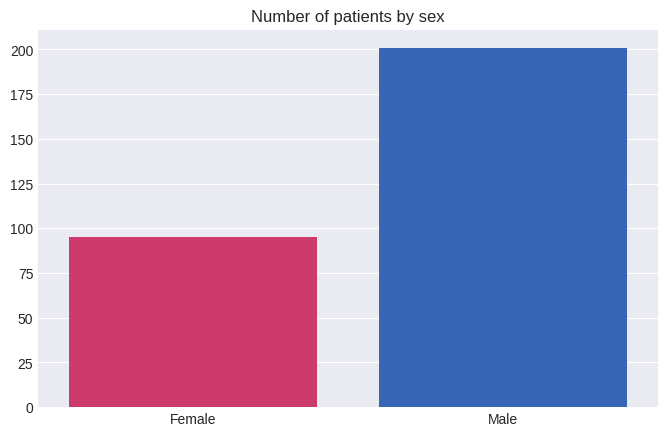

In [12]:
sexes = pd.DataFrame(df['sex'].value_counts().sort_index())

ax = sns.barplot(data=sexes, x=sexes.index, y='sex', palette=SEX_COLORS)

plt.title('Number of patients by sex')
plt.xlabel('')
plt.ylabel('')

plt.xticks(ticks=range(len(SEX_LABELS)), labels=SEX_LABELS);

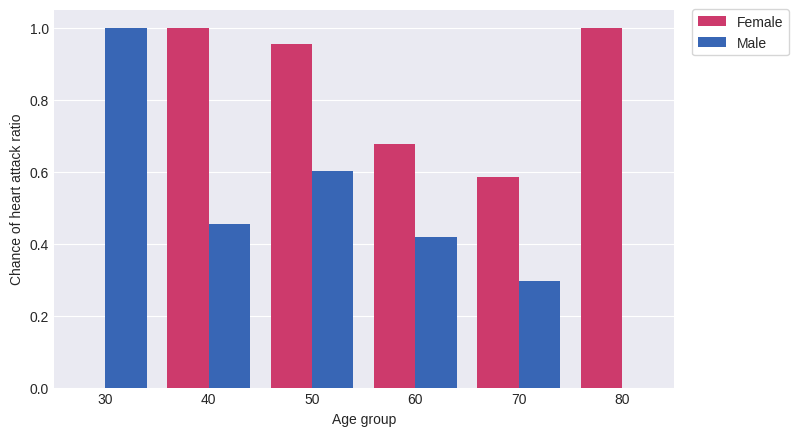

In [13]:
heart_attack_by_sex('age_group', 'Age group')

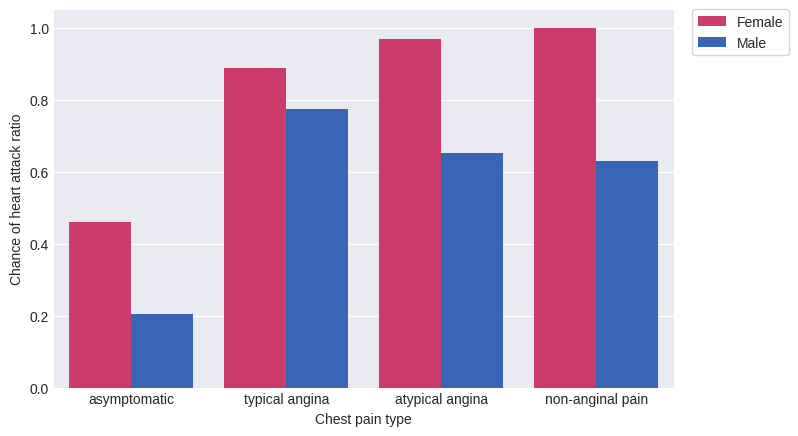

In [14]:
heart_attack_by_sex('cp', 'Chest pain type', ['asymptomatic', 'typical angina', 'atypical angina', 'non-anginal pain'])

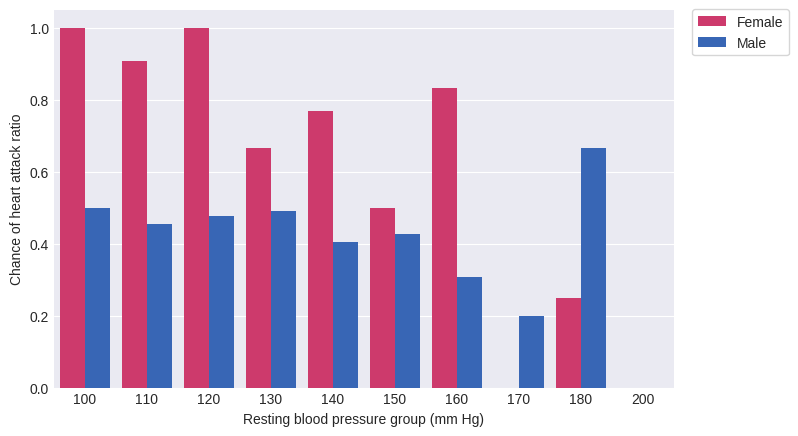

In [15]:
heart_attack_by_sex('trtbps_group', 'Resting blood pressure group (mm Hg)')

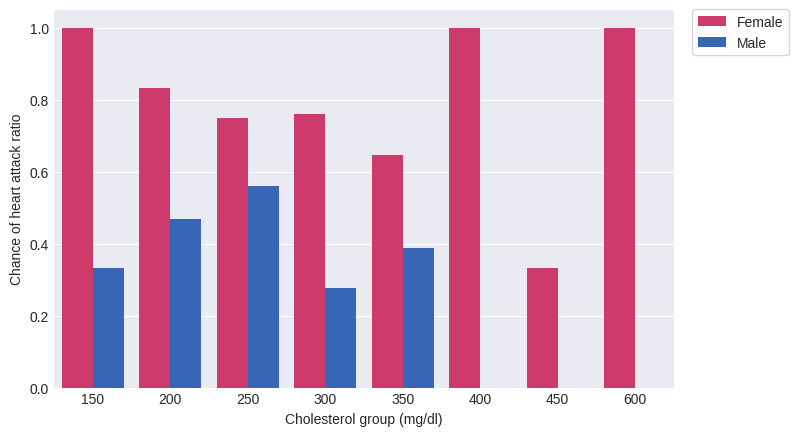

In [16]:
heart_attack_by_sex('chol_group', 'Cholesterol group (mg/dl)')

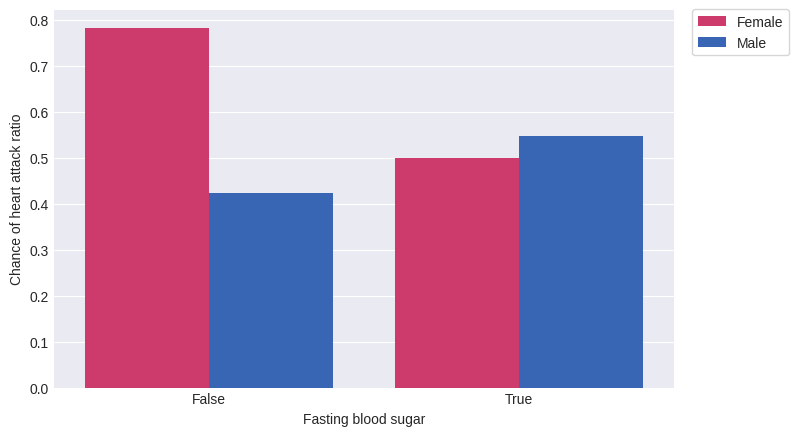

In [17]:
heart_attack_by_sex('fbs', 'Fasting blood sugar', ['False', 'True'])

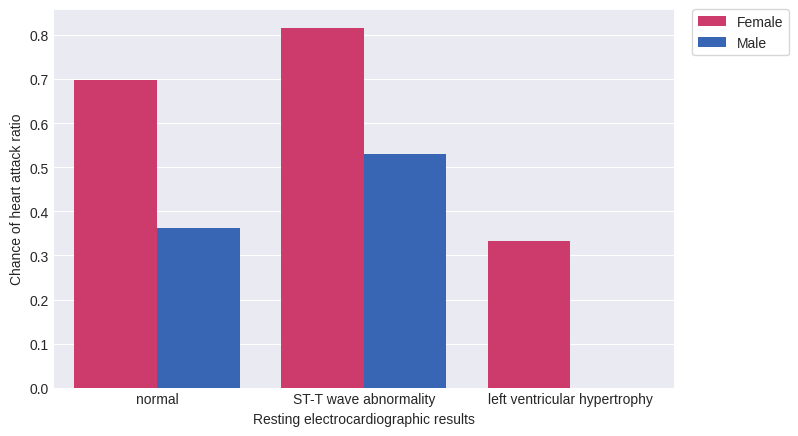

In [18]:
heart_attack_by_sex('restecg', 'Resting electrocardiographic results', ['normal', 'ST-T wave abnormality', 'left ventricular hypertrophy'])

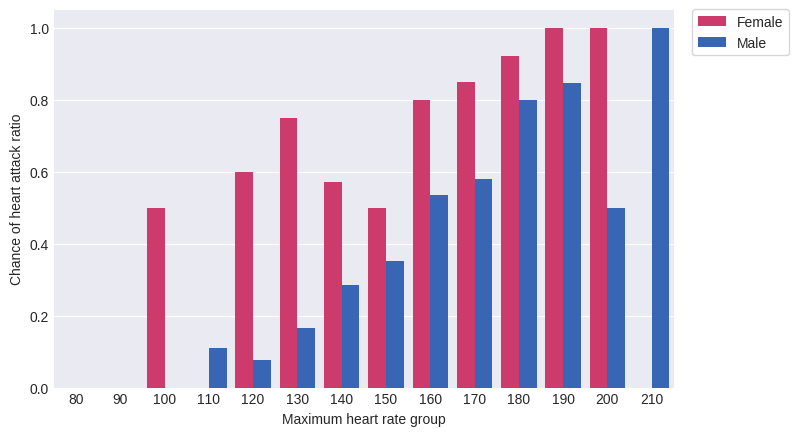

In [19]:
heart_attack_by_sex('thalachh_group', 'Maximum heart rate group')

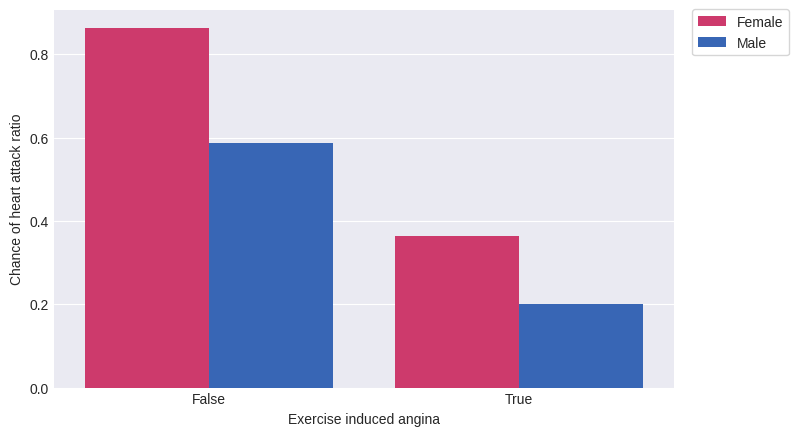

In [20]:
heart_attack_by_sex('exng', 'Exercise induced angina', ['False', 'True'])

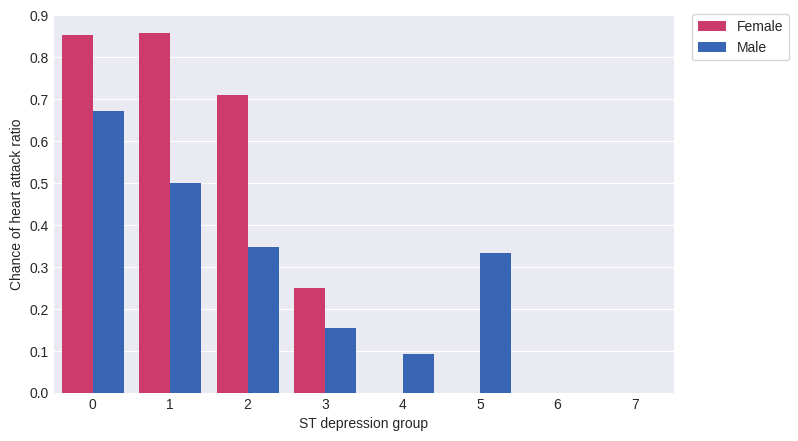

In [21]:
heart_attack_by_sex('oldpeak_group', 'ST depression group')

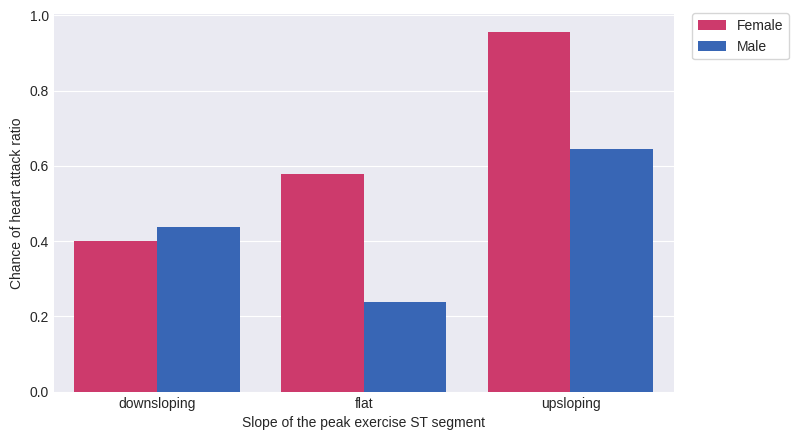

In [22]:
heart_attack_by_sex('slp', 'Slope of the peak exercise ST segment', ['downsloping', 'flat', 'upsloping'])

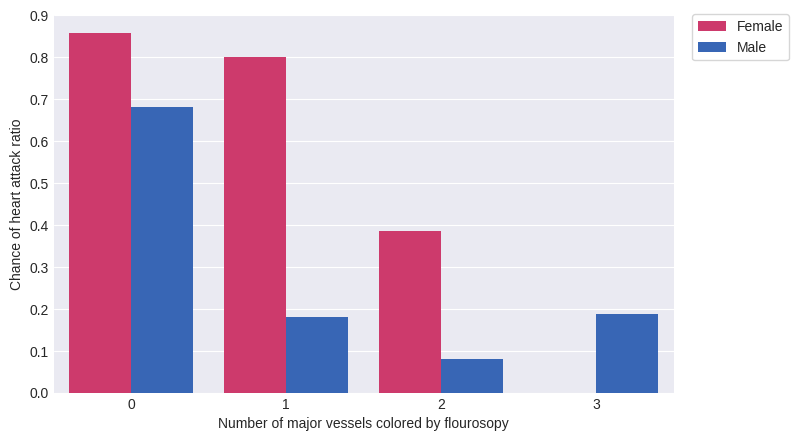

In [23]:
heart_attack_by_sex('caa', 'Number of major vessels colored by flourosopy')

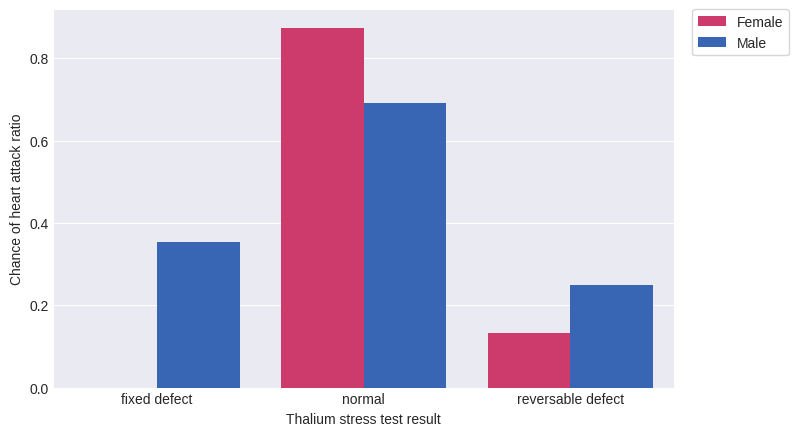

In [24]:
heart_attack_by_sex('thall', 'Thalium stress test result', ['fixed defect', 'normal', 'reversable defect'])

# Train and test split and scaling

In [25]:
df.drop(['age_group', 'trtbps_group', 'chol_group', 'thalachh_group', 'oldpeak_group'], axis=1, inplace=True)

X = df.drop('output', axis=1)
y = df['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# Classification models

In [26]:
evaluations = [None] * 20

## Model 0: KNN

In [27]:
%%time

knn = KNeighborsClassifier(n_neighbors=12)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

CPU times: user 5.85 ms, sys: 0 ns, total: 5.85 ms
Wall time: 9.92 ms


              precision    recall  f1-score   support

           0       0.76      0.81      0.79        27
           1       0.84      0.79      0.81        33

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60



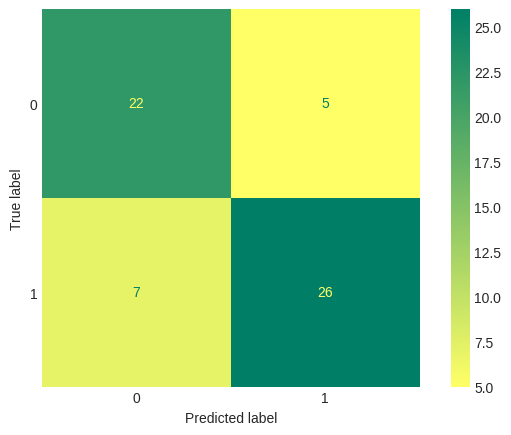

In [28]:
evaluations[0] = evaluate_model(y_test, y_pred, True)

In [29]:
evaluations[0]

{'accuracy': 0.8,
 'precision': 0.8026696329254729,
 'recall': 0.8,
 'f1-score': 0.8004464285714286}

## Model 1: Ridge

In [30]:
%%time

rid = RidgeClassifier(alpha=0.0, fit_intercept=False, random_state=SEED)

rid.fit(X_train, y_train)

y_pred = rid.predict(X_test)

CPU times: user 3.52 ms, sys: 0 ns, total: 3.52 ms
Wall time: 3.53 ms


              precision    recall  f1-score   support

           0       0.77      0.89      0.83        27
           1       0.90      0.79      0.84        33

    accuracy                           0.83        60
   macro avg       0.84      0.84      0.83        60
weighted avg       0.84      0.83      0.83        60



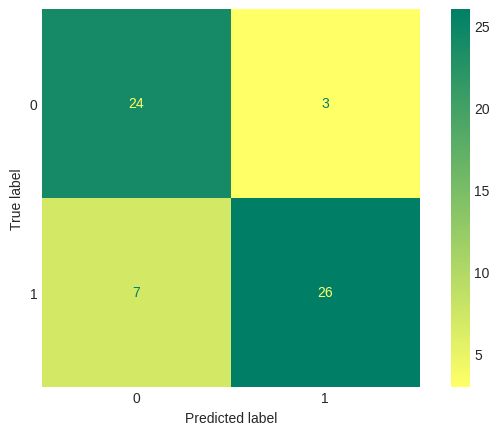

In [31]:
evaluations[1] = evaluate_model(y_test, y_pred, True)

In [32]:
evaluations[1]

{'accuracy': 0.8333333333333334,
 'precision': 0.8414905450500556,
 'recall': 0.8333333333333334,
 'f1-score': 0.8337041156840935}

## Model 2: SVM

In [33]:
%%time

svm = SVC(C=4.0, kernel='sigmoid', random_state=SEED)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

CPU times: user 7.64 ms, sys: 59 µs, total: 7.7 ms
Wall time: 16.4 ms


              precision    recall  f1-score   support

           0       0.79      0.85      0.82        27
           1       0.87      0.82      0.84        33

    accuracy                           0.83        60
   macro avg       0.83      0.84      0.83        60
weighted avg       0.84      0.83      0.83        60



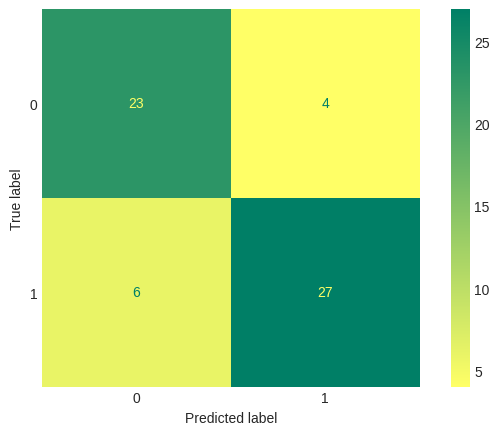

In [34]:
evaluations[2] = evaluate_model(y_test, y_pred, True)

In [35]:
evaluations[2]

{'accuracy': 0.8333333333333334,
 'precision': 0.8359288097886541,
 'recall': 0.8333333333333334,
 'f1-score': 0.8337053571428572}

## Model 3: Decision Tree

In [36]:
%%time

dtc = DecisionTreeClassifier(criterion='gini', splitter='random', random_state=SEED)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

CPU times: user 2.45 ms, sys: 0 ns, total: 2.45 ms
Wall time: 11.9 ms


              precision    recall  f1-score   support

           0       0.79      0.81      0.80        27
           1       0.84      0.82      0.83        33

    accuracy                           0.82        60
   macro avg       0.81      0.82      0.82        60
weighted avg       0.82      0.82      0.82        60



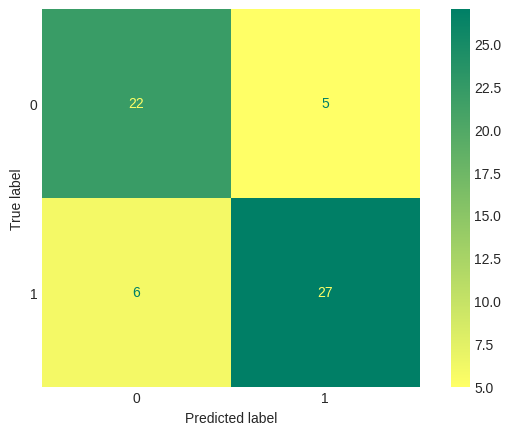

In [37]:
evaluations[3] = evaluate_model(y_test, y_pred, True)

In [38]:
evaluations[3]

{'accuracy': 0.8166666666666667,
 'precision': 0.8176339285714286,
 'recall': 0.8166666666666667,
 'f1-score': 0.816923076923077}

## Model 4: Multi-layer Perceptron

In [39]:
%%time

mlp = MLPClassifier(hidden_layer_sizes=120, activation='relu', solver='sgd', learning_rate_init=0.001, max_iter=700, random_state=SEED)

mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)

CPU times: user 1.85 s, sys: 2.25 s, total: 4.11 s
Wall time: 4.39 s


              precision    recall  f1-score   support

           0       0.80      0.89      0.84        27
           1       0.90      0.82      0.86        33

    accuracy                           0.85        60
   macro avg       0.85      0.85      0.85        60
weighted avg       0.85      0.85      0.85        60



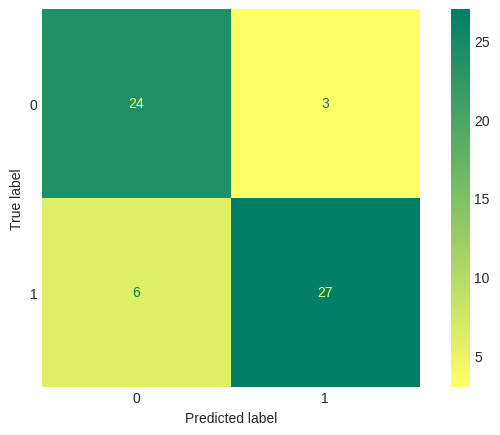

In [40]:
evaluations[4] = evaluate_model(y_test, y_pred, True)

In [41]:
evaluations[4]

{'accuracy': 0.85,
 'precision': 0.855,
 'recall': 0.85,
 'f1-score': 0.8503759398496241}

# Comparing models

In [42]:
df_evaluations = pd.DataFrame([e for e in evaluations if e is not None])
df_evaluations.T

,0,1,2,3,4
accuracy,0.800000,0.833333,0.833333,0.816667,0.850000
precision,0.802670,0.841491,0.835929,0.817634,0.855000
recall,0.800000,0.833333,0.833333,0.816667,0.850000
f1-score,0.800446,0.833704,0.833705,0.816923,0.850376


In [43]:
df_evaluations['f1-score'].sort_values(ascending=False)

4    0.850376
2    0.833705
1    0.833704
3    0.816923
0    0.800446
Name: f1-score, dtype: float64